In [81]:
import os, sklearn, math
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from joblib import dump, load

tf.random.set_seed(42)

data = '230710_Axial_z2_Data'
dataname = data+'230807'+'_02'
filename = 'myData/'+data+'.csv'
SD1 = pd.read_csv(filename)
SD1=SD1.iloc[:,:13]
SensorData1 = SD1

In [82]:
SD1.sample(5)

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Force,encoder,z,theta,r
40329,44,44,46,43,55,42,29,68.95,-729.93,26,0,8.0
186777,48,30,43,37,39,37,49,65.74,-3713.47,130,0,7.2
154769,56,46,43,39,41,41,49,51.82,-2956.29,108,0,4.8
3081,46,49,48,36,45,46,49,-1.69,-30.15,2,0,1.6
91103,49,49,51,40,35,39,48,81.65,-2733.75,62,0,8.0


In [83]:
SDreal = SD1

In [84]:
SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Force,encoder,z,theta,r
count,226477.000000,226477.000000,226477.000000,226477.000000,226477.000000,226477.000000,226477.000000,226477.000000,226477.000000,226477.000000,226477.0,226477.000000
mean,48.346185,44.993116,48.101167,40.125554,44.090053,43.143569,47.287703,42.117940,-2505.894559,78.630024,0.0,4.797753
std,84.095088,59.711839,78.833617,66.752353,78.681733,89.272349,66.636892,24.206043,1448.535114,46.262884,0.0,2.066331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-483.760000,-5209.280000,0.000000,0.0,1.600000
25%,46.000000,43.000000,46.000000,37.000000,41.000000,40.000000,45.000000,23.220000,-3288.870000,38.000000,0.0,3.200000
50%,48.000000,45.000000,48.000000,40.000000,43.000000,42.000000,48.000000,42.420000,-2819.360000,78.000000,0.0,4.800000
75%,50.000000,47.000000,50.000000,43.000000,46.000000,45.000000,50.000000,60.550000,-1591.520000,118.000000,0.0,6.400000
max,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,103.350000,124.190000,158.000000,0.0,8.000000


In [85]:
# SDreal 값이 0보다 작은데 encoder 인 것 제거
SDreal = SDreal[~((SDreal < 0)&(SDreal.columns != "encoder")).any(axis=1)]
#SDreal = SDreal[~((SDreal['z'] % 2 == 0) & (SDreal['z'] % 4 != 0))]

# SDreal 값이 100보다 크거나 0인데, 'theta', 'z', 'Force' 열이 아닌 것 제거
SDreal = SDreal[~(((SDreal >= 80)|(SDreal == 0) ) & 
                 (SDreal.columns != "theta") &
                 (SDreal.columns != "z") &
                 (SDreal.columns != "Force") &
                  (SDreal.columns != "encoder")).any(axis=1)]

# SDreal 값이 8191이거나 8190인 것 제거
SDreal = SDreal[~((SDreal == 8191) | (SDreal == 8190)).any(axis=1)]

# SDreal에서 결측값 제거
SDreal = SDreal[~SDreal.isna().any(axis=1)]

SDreal = SDreal[~((SDreal >= 800) & (SDreal.columns == "Force")).any(axis=1)]
SDreal = SDreal[~((SDreal <= -300) & (SDreal.columns == "Force")).any(axis=1)]

# k = 3
# for col in SDreal.columns:
#     mean = SDreal[col].mean()
#     std = SDreal[col].std()

#     outliers = (SDreal[col] < mean - k*std) | (SDreal[col] > mean + k*std)
#     SDreal = SDreal[~outliers]


SDreal = SDreal[SDreal["r"] >= 0.8*1]
SDreal = SDreal[SDreal["z"] <= 150]
SDreal = SDreal[SDreal["z"] >= 10]

SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Force,encoder,z,theta,r
count,198009.000000,198009.000000,198009.000000,198009.000000,198009.000000,198009.000000,198009.000000,198009.000000,198009.000000,198009.000000,198009.0,198009.000000
mean,48.083734,44.908767,47.459722,39.813736,43.574272,42.411289,46.669060,44.625490,-2557.588014,80.135842,0.0,4.815220
std,3.557945,4.484135,3.905149,4.430663,3.919053,3.774989,4.311958,22.876202,1226.557613,40.826157,0.0,2.058666
min,12.000000,26.000000,28.000000,20.000000,22.000000,27.000000,4.000000,0.000000,-5005.110000,10.000000,0.0,1.600000
25%,46.000000,43.000000,45.000000,37.000000,41.000000,40.000000,45.000000,25.320000,-3123.020000,44.000000,0.0,3.200000
50%,48.000000,45.000000,48.000000,40.000000,43.000000,42.000000,47.000000,45.140000,-2822.260000,80.000000,0.0,4.800000
75%,50.000000,48.000000,50.000000,43.000000,46.000000,45.000000,50.000000,63.150000,-2091.620000,116.000000,0.0,6.400000
max,62.000000,71.000000,77.000000,64.000000,75.000000,57.000000,58.000000,103.350000,124.010000,150.000000,0.0,8.000000


In [86]:
def apply_transformation(df, columns, transformation):
    # columns가 제공되지 않았다면 df의 모든 칼럼을 대상으로 함
    if columns is None:
        columns = df.columns

    for column in columns:
        df[column] = transformation(df[column])
    
    return df

def normalize(column):
    return (column - column.mean()) / (column.max() - column.min())*2

def standardize(column):
    return (column - column.mean()) / column.std()

def submean(column):
    return (column - column.mean())



SDreal = apply_transformation(SDreal.copy(), ['r', 'Force', 'z'], normalize)
#SDreal = apply_transformation(SDreal.copy(), ['Sx00','Sx01','Sx02','Sx03','Sx04','Sx05','Sx06','Sx07'], normalize)

#SDreal = apply_transformation(SDreal.copy(), ['r', 'Force', 'z'], submean)
#SDreal = apply_transformation(SDreal.copy(), ['Sx00','Sx01','Sx02','Sx03','Sx04','Sx05','Sx06','Sx07'], standardize)

SDreal

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Force,encoder,z,theta,r
14863,48,46,43,48,44,44,51,-0.744760,50.27,-1.001941,0,-0.754756
14864,48,46,43,48,44,44,51,-0.744567,50.27,-1.001941,0,-0.754756
14865,48,46,43,48,44,44,52,-0.745728,50.27,-1.001941,0,-0.754756
14866,48,43,43,44,44,44,52,-0.747083,50.27,-1.001941,0,-0.754756
14867,47,43,44,44,44,44,52,-0.748244,50.27,-1.001941,0,-0.754756
...,...,...,...,...,...,...,...,...,...,...,...,...
215228,30,43,49,39,43,40,52,0.326744,-4993.42,0.998059,0,0.995244
215229,30,43,49,39,42,42,51,0.328099,-4993.59,0.998059,0,0.995244
215230,30,41,49,39,42,42,51,0.327712,-4993.24,0.998059,0,0.995244
215231,30,41,49,39,42,42,48,0.326551,-4993.07,0.998059,0,0.995244


In [87]:
SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Force,encoder,z,theta,r
count,198009.000000,198009.000000,198009.000000,198009.000000,198009.000000,198009.000000,198009.000000,1.980090e+05,198009.000000,1.980090e+05,198009.0,1.980090e+05
mean,48.083734,44.908767,47.459722,39.813736,43.574272,42.411289,46.669060,-1.341108e-14,-2557.588014,1.368263e-13,0.0,5.599836e-13
std,3.557945,4.484135,3.905149,4.430663,3.919053,3.774989,4.311958,4.426938e-01,1226.557613,5.832308e-01,0.0,6.433332e-01
min,12.000000,26.000000,28.000000,20.000000,22.000000,27.000000,4.000000,-8.635799e-01,-5005.110000,-1.001941e+00,0.0,-1.004756e+00
25%,46.000000,43.000000,45.000000,37.000000,41.000000,40.000000,45.000000,-3.735944e-01,-3123.020000,-5.162263e-01,0.0,-5.047561e-01
50%,48.000000,45.000000,48.000000,40.000000,43.000000,42.000000,47.000000,9.956655e-03,-2822.260000,-1.940604e-03,0.0,-4.756097e-03
75%,50.000000,48.000000,50.000000,43.000000,46.000000,45.000000,50.000000,3.584811e-01,-2091.620000,5.123451e-01,0.0,4.952439e-01
max,62.000000,71.000000,77.000000,64.000000,75.000000,57.000000,58.000000,1.136420e+00,124.010000,9.980594e-01,0.0,9.952439e-01


In [88]:
SDy = SDreal.iloc[:,[7,9]]
SDy.describe()

,Force,z
count,1.980090e+05,1.980090e+05
mean,-1.341108e-14,1.368263e-13
std,4.426938e-01,5.832308e-01
min,-8.635799e-01,-1.001941e+00
25%,-3.735944e-01,-5.162263e-01
50%,9.956655e-03,-1.940604e-03
75%,3.584811e-01,5.123451e-01
max,1.136420e+00,9.980594e-01


In [89]:
X = SDreal.iloc[:,0:7]
y = SDreal.iloc[:,[7,9]]

In [90]:
X

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06
14863,48,46,43,48,44,44,51
14864,48,46,43,48,44,44,51
14865,48,46,43,48,44,44,52
14866,48,43,43,44,44,44,52
14867,47,43,44,44,44,44,52
...,...,...,...,...,...,...,...
215228,30,43,49,39,43,40,52
215229,30,43,49,39,42,42,51
215230,30,41,49,39,42,42,51
215231,30,41,49,39,42,42,48


In [91]:
y.sample(5)

,Force,z
179826,-0.029714,0.655202
177192,0.208118,0.626631
116080,0.399120,-0.001941
138644,0.415956,0.226631
67281,0.017504,-0.487655


In [92]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.01, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size = 0.2, random_state=42)

In [93]:
X_sum = len(X_train)+len(X_valid)+len(X_test)
X_train_per = int(len(X_train)/X_sum*100)
X_valid_per = int(len(X_valid)/X_sum*100)
X_test_per = int(len(X_test)/X_sum*100)

print('X_train: ',len(X_train),'ea',X_train_per,'%   ', 
      'X_valid: ',len(X_valid),'ea',X_valid_per,'%   ',
      'X_test: ',len(X_test),'ea',X_test_per,'%',)

X_train:  156822 ea 79 %    X_valid:  39206 ea 19 %    X_test:  1981 ea 1 %


In [94]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [95]:
import pickle
from joblib import dump, load

file_name = 'myScaler/'+dataname+'_SS.pkl'
dump(scaler, file_name)

['myScaler/230710_Axial_z2_Data230807_02_SS.pkl']

In [96]:
from tensorflow import keras
model = keras.models.Sequential([   
    keras.layers.Dense(128, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),
    keras.layers.Dense(64, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),            
    keras.layers.Dense(32, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),            
    keras.layers.Dense(16, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),        
    keras.layers.Dense(8, activation="relu", input_shape=X_train.shape[1:],kernel_initializer = "he_normal"),        
    keras.layers.Dense(2)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.RMSprop(learning_rate=1e-5, rho=0.9))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 128)               1024      
                                                                 
 dense_19 (Dense)            (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 32)                2080      
                                                                 
 dense_21 (Dense)            (None, 16)                528       
                                                                 
 dense_22 (Dense)            (None, 8)                 136       
                                                                 
 dense_23 (Dense)            (None, 2)                 18        
                                                                 
Total params: 12,042
Trainable params: 12,042
Non-trai

## Callback (best, early stopping, tensorboard)

In [97]:
import os 
#root_logdir = os.path.join(os.curdir, 'mylog/'+data)
root_logdir = os.path.join(os.curdir, 'mylog/'+'230320_Data')

def get_run_logdir():
    import time
    run_id= time.strftime("%m%d_%Hh%Mm%Ss"+dataname)
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [98]:
K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [99]:
dataname

'230710_Axial_z2_Data230807_02'

In [100]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
n_epochs = 300
batch_size = 40
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train, y_train, epochs=n_epochs,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle,early_stopping_cb,tensorboard_cb])
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:5]
y_pred = model.predict(X_new)

Epoch 1/300
4901/4901 [==============================] - 6s 1ms/step - loss: 0.0567 - val_loss: 0.0519
Epoch 2/300
4901/4901 [==============================] - 5s 1ms/step - loss: 0.0499 - val_loss: 0.0486
Epoch 3/300
4901/4901 [==============================] - 6s 1ms/step - loss: 0.0492 - val_loss: 0.0477
Epoch 4/300
4901/4901 [==============================] - 5s 1ms/step - loss: 0.0489 - val_loss: 0.0517
Epoch 5/300
4901/4901 [==============================] - 6s 1ms/step - loss: 0.0489 - val_loss: 0.0487
Epoch 6/300
4901/4901 [==============================] - 5s 1ms/step - loss: 0.0491 - val_loss: 0.0522
Epoch 7/300
4901/4901 [==============================] - 5s 1ms/step - loss: 0.0493 - val_loss: 0.0519
Epoch 8/300
4901/4901 [==============================] - 6s 1ms/step - loss: 0.0495 - val_loss: 0.0474
Epoch 9/300
4901/4901 [==============================] - 6s 1ms/step - loss: 0.0499 - val_loss: 0.0473
Epoch 10/300
4901/4901 [==============================] - 6s 1ms/step - l

In [71]:
# %load_ext tensorboard
# %tensorboard --logdir=./mylog/230320_Data --port=2322

In [72]:
model.save('D:/ME program/2017-PhD/01_research/02Study/34_ballon_like_cover/DeepLearing/TACTS/TACTS_v1/myModel/'+dataname+'.h5')

In [73]:
model = tf.keras.models.load_model('myModel/'+dataname+'.h5')
scaler = load(file_name)
valid_predictions = model.predict(X_valid)

valid_predictions_df=pd.DataFrame(valid_predictions)
valid_predictions_df.columns = ["valid_force","valid_z"]
#valid_predictions_df.columns = ["valid_force","valid_z","valid_r"]
valid_predictions_df

k= y_valid.to_numpy()
k_df = pd.DataFrame(k)
#k_df.columns  = ["force","z","r"]
k_df.columns  = ["force","z"]
k_df.describe()

1226/1226 [==============================] - 1s 589us/step


,force,z
count,39206.000000,39206.000000
mean,0.000879,0.002119
std,0.440978,0.584374
min,-0.862419,-1.001941
25%,-0.366821,-0.516226
50%,0.013246,-0.001941
75%,0.354030,0.512345
max,1.092105,0.998059


In [74]:
ValidPre = pd.concat( [k_df,valid_predictions_df],axis=1)
ValidPre.head(5)
corr = ValidPre.corr()
print("corr")
n = k_df.shape[1]
for i in range(0,n):    
    print(format(corr[valid_predictions_df.columns[i]][k_df.columns[i]]*100,'.2f')+'%',k_df.columns[i])
corr

corr
88.78% force
92.54% z


,force,z,valid_force,valid_z
force,1.000000,0.089850,0.887788,0.100747
z,0.089850,1.000000,0.138122,0.925360
valid_force,0.887788,0.138122,1.000000,0.159239
valid_z,0.100747,0.925360,0.159239,1.000000


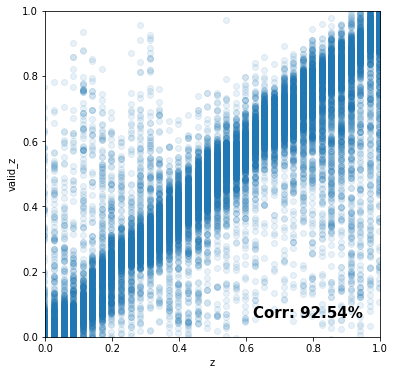

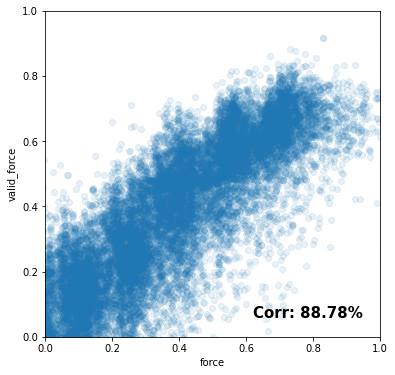

In [75]:
import pandas as pd
import os
import matplotlib.pyplot as plt

alpa = 0.1
output_dir = "myLearningData/savefig"  # 저장할 폴더 이름

# 폴더가 없는 경우 폴더를 생성합니다.
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

fields = ['z', 'force']

for field in fields:
    plt.figure(figsize=(6, 6))  # Set the figure size to 1:1
    plt.scatter(ValidPre[field], ValidPre[f"valid_{field}"], alpha=alpa)
    plt.xlabel(field)
    plt.ylabel(f"valid_{field}")
    plt.xlim(0, 1)  # x축 범위 설정
    plt.ylim(0, 1)  # y축 범위 설정

    # Compute the correlation value to be added
    corr_value = format(corr[f"valid_{field}"][field]*100,'.2f') + '%'
    plt.text(0.95, 0.05, f'Corr: {corr_value}', ha='right', va='bottom', 
             transform=plt.gca().transAxes, fontsize=15, weight='bold')

    plt.savefig(os.path.join(output_dir, f"{dataname}_{field}.png"))  # 플롯을 지정된 폴더에 PNG 파일로 저장
    plt.show()
